In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [4]:
df.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


In [5]:
df = df.drop(columns = ['id'])

In [6]:
y = df['Hardness']
X = df.drop(columns='Hardness')

In [7]:
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 6243 samples 	 60%
Test:  2082 samples 	 20%
Val:   2082 samples 	 20%


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


In [10]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 Index([], dtype='object'))])

In [11]:
# навчання препроцесора
X_train = preprocessor.fit_transform(X_train)

# обробка даних
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [12]:
from sklearn import metrics


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  # params = {
  #       'objective': 'mse',
  #       'n_estimator': 30,
  #       'verbose': -1,
  #       'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
  #       'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
  #       'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
  #       'num_leaves': trial.suggest_int('num_leaves', 2, 256),
  #       'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
  #       'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
  #       'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
  #       'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
  #   }

  params = {
    'objective': 'mse',
    'n_estimators': 1000,
    'verbose': -1,
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    #'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    #'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
    #'subsample': trial.suggest_float('subsample', 0.4, 1.0),
    #'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
    #'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 100.0, log=True),
    }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)
  mae = metrics.mean_absolute_error(y_val, y_pred)
  rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5

  # 5. Повернення значення метрики:
  return r2, mae, rmse

In [13]:
!pip install -q optuna

In [14]:
import optuna
study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=10)

[I 2024-07-14 12:36:23,264] A new study created in memory with name: no-name-2ad22c44-be3c-4137-b7ae-8f766c58326a
[I 2024-07-14 12:36:34,274] Trial 0 finished with values: [-0.392740847158193, 1.6718374458118153, 1.9896456006319663] and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.6892889979507602, 'lambda_l2': 0.00040150990735629175, 'bagging_freq': 5, 'learning_rate': 0.003980763156784839, 'colsample_bytree': 0.9954528580699307}. 
[I 2024-07-14 12:36:36,106] Trial 1 finished with values: [0.46160644623345626, 0.9066975631844948, 1.2370592332298116] and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.0886940259747665e-07, 'lambda_l2': 3.9318626253387196e-08, 'bagging_freq': 3, 'learning_rate': 0.03712448584650894, 'colsample_bytree': 0.8727873414610792}. 
[I 2024-07-14 12:36:51,900] Trial 2 finished with values: [-4.498420662057407, 3.597495840361241, 3.9532979831980044] and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.5039387911353593, 'lambda_l2': 0.125693217579

In [15]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.461780,0.905222,1.236860
1,0.469996,0.916354,1.227384


In [16]:
best_params = study.best_trials[1].params

In [17]:
model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 10,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_freq=5, colsample_bytree=0.5838170997485839,
              lambda_l1=2.788829975962483, lambda_l2=1.3504638752461746,
              learning_rate=0.003450053632736693, n_estimator=10, verbose=-1)

In [18]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [19]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,1.30,1.29
RMSE,1.50,1.47
R2,0.21,0.20


In [20]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

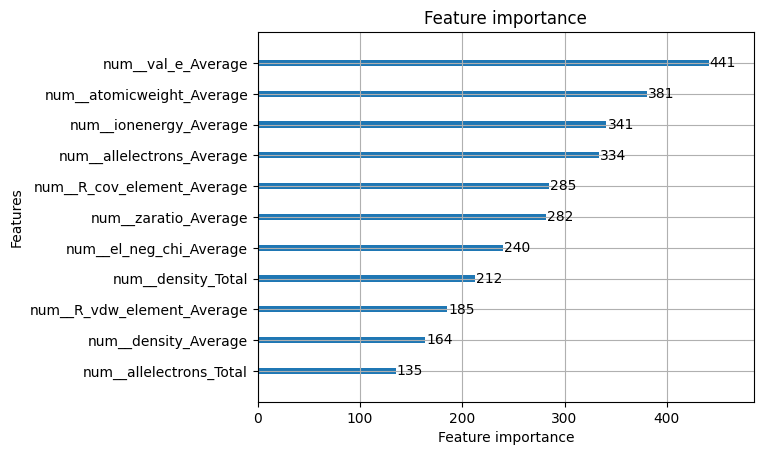

In [21]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

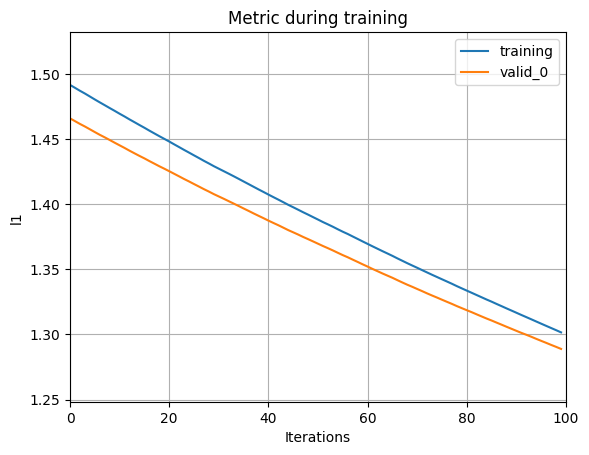

In [22]:
lgb.plot_metric(model,
                metric='l1')

In [23]:
import joblib
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']